In [1]:
import torch
import numpy as np
from source.utils import parse_csv
from rdkit import Chem
from source.utils.mol_utils import smi_reader_params, preprocess_mol, get_molecule_fragments
from rdkit.Chem import rdDistGeom, AllChem, rdMolTransforms, Descriptors
from source.scripts.fg_featurizer import FGFeaturizer
from geqtrain.utils.torch_geometric import Data
from source.utils.data_utils.featurizer import atom_to_feature_vector, possible_atomic_properties, possible_bond_properties, bond_to_feature_vector, allowable_features
from collections import defaultdict
from einops import repeat
from source.data_transforms.utils import get_torsions, GetDihedral
from source.utils.npz_utils import save_npz
from tqdm import tqdm
import os
import multiprocessing as mp
from functools import partial
from source.utils.data_splitting_utils import scaffold_splitter

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/nobilm@usi.ch/miniconda3/envs/pretrain/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch

In [2]:
path:str = '/home/nobilm@usi.ch/pretrain_paper/data/zinc_with_safe.csv'
out = parse_csv(path, [0, -1])
smiles = out['smiles'] # after SAFE this is fixed
safe_counts = out['num_of_chunks_in_mol'] #out['num_of_chunks_in_mol'] # after SAFE this is fixed
mols = [Chem.MolFromSmiles(s, smi_reader_params(removeHs=True)) for s in smiles]
mols = [preprocess_mol(mol, addHs=False) for mol in mols]
rotable_bonds = [get_torsions(mol) for mol in mols]

In [10]:
# import matplotlib.pyplot as plt

# rot_bond_counts = [len(bonds) for bonds in rotable_bonds]
# plt.hist(rot_bond_counts, bins=range(min(rot_bond_counts), max(rot_bond_counts) + 2), color='skyblue', edgecolor='black')
# plt.title('Histogram of Rotatable Bonds per Molecule')
# plt.xlabel('Number of Rotatable Bonds')
# plt.ylabel('Frequency')
# plt.show()

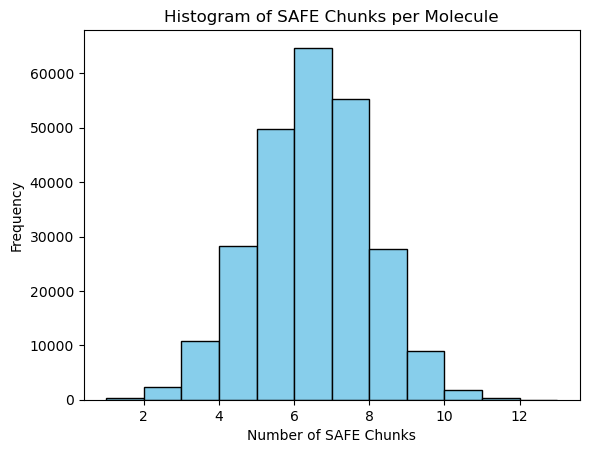

In [5]:
import matplotlib.pyplot as plt

plt.hist(safe_counts, bins=range(min(safe_counts), max(safe_counts) + 2), color='skyblue', edgecolor='black')
plt.title('Histogram of SAFE Chunks per Molecule')
plt.xlabel('Number of SAFE Chunks')
plt.ylabel('Frequency')
plt.show()

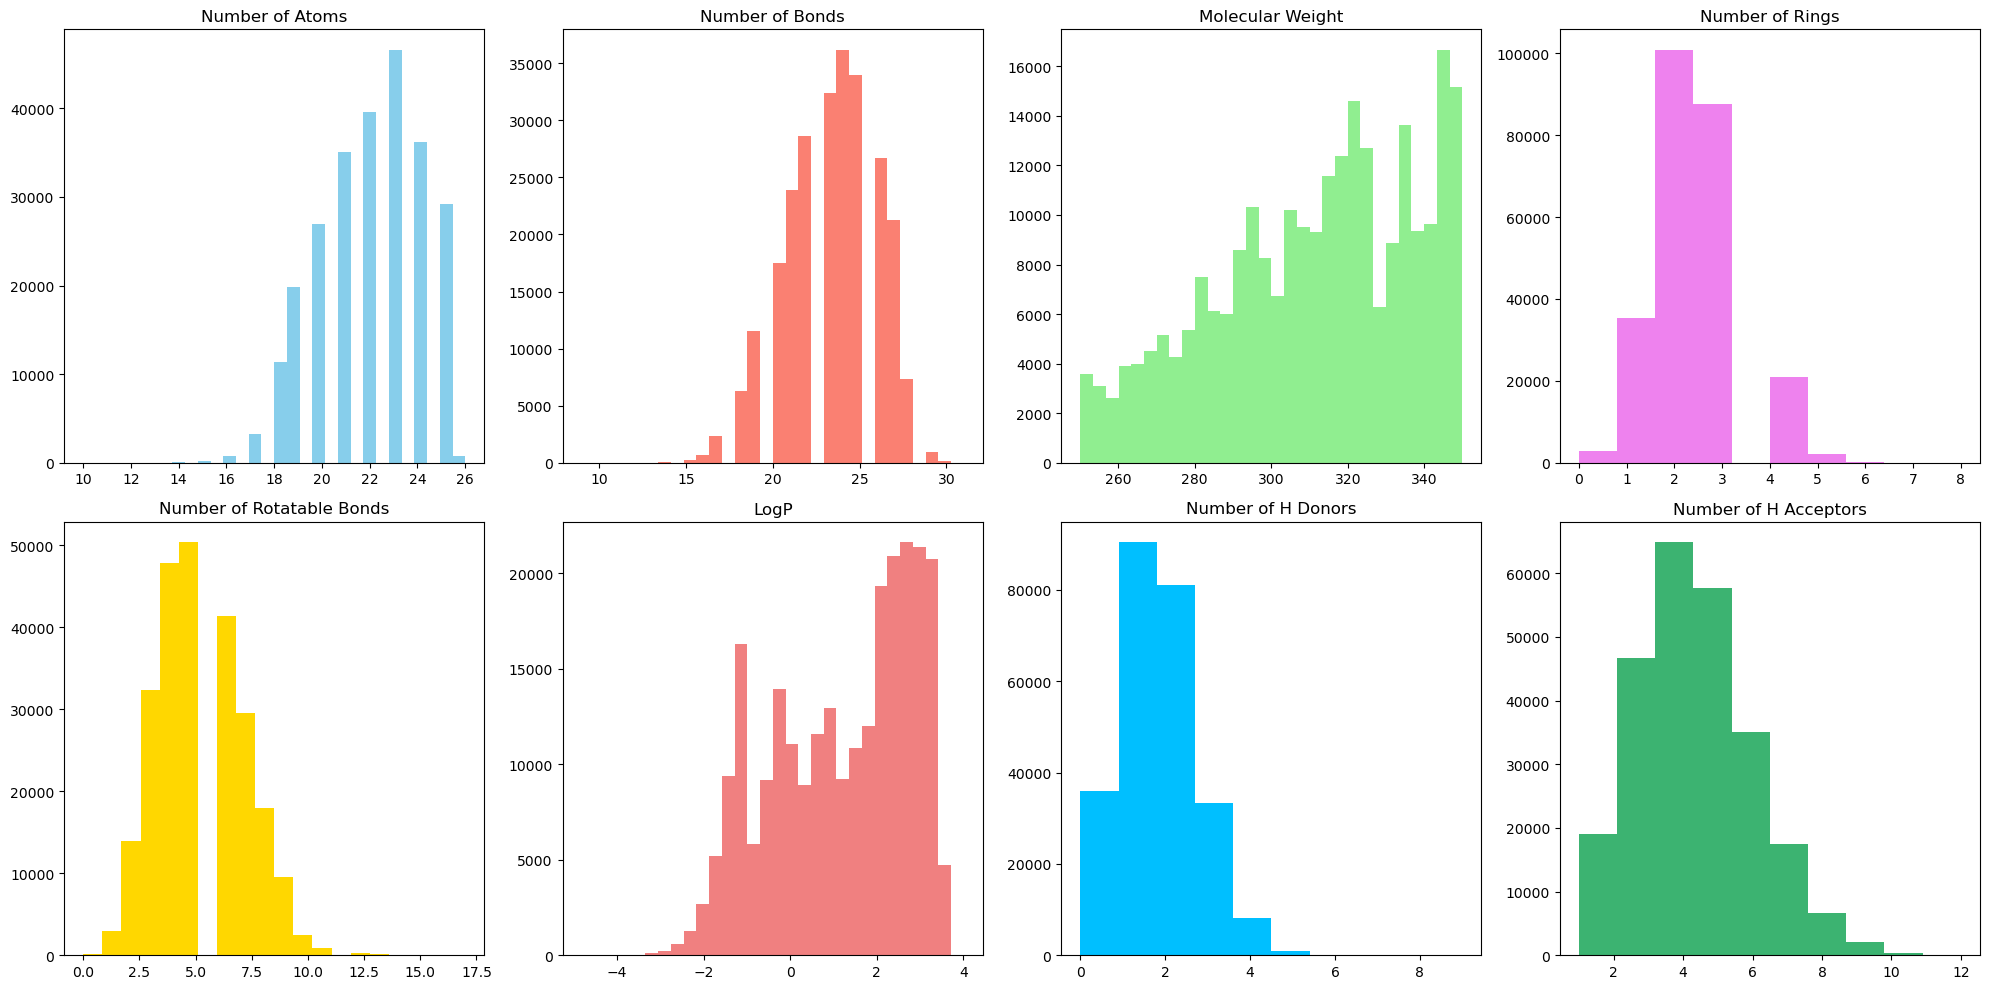

Number of molecules: 250000
Average number of atoms: 21.97
Average number of bonds: 23.34
Average molecular weight: 311.23
Average number of rings: 2.38
Average number of rotatable bonds: 5.19
Average LogP: 1.21
Average number of H donors: 1.56
Average number of H acceptors: 4.54


In [3]:
from rdkit.Chem import Descriptors

# Calculate basic structural and non-structural properties for the molecules
num_mols = len(mols)
num_atoms = [mol.GetNumAtoms() for mol in mols]
num_bonds = [mol.GetNumBonds() for mol in mols]
mol_weights = [Descriptors.MolWt(mol) for mol in mols]
num_rings = [Descriptors.RingCount(mol) for mol in mols]
num_rotatable_bonds = [Descriptors.NumRotatableBonds(mol) for mol in mols]
logp = [Descriptors.MolLogP(mol) for mol in mols]
num_h_donors = [Descriptors.NumHDonors(mol) for mol in mols]
num_h_acceptors = [Descriptors.NumHAcceptors(mol) for mol in mols]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

axs[0].hist(num_atoms, bins=30, color='skyblue')
axs[0].set_title('Number of Atoms')

axs[1].hist(num_bonds, bins=30, color='salmon')
axs[1].set_title('Number of Bonds')

axs[2].hist(mol_weights, bins=30, color='lightgreen')
axs[2].set_title('Molecular Weight')

axs[3].hist(num_rings, bins=10, color='violet')
axs[3].set_title('Number of Rings')

axs[4].hist(num_rotatable_bonds, bins=20, color='gold')
axs[4].set_title('Number of Rotatable Bonds')

axs[5].hist(logp, bins=30, color='lightcoral')
axs[5].set_title('LogP')

axs[6].hist(num_h_donors, bins=10, color='deepskyblue')
axs[6].set_title('Number of H Donors')

axs[7].hist(num_h_acceptors, bins=10, color='mediumseagreen')
axs[7].set_title('Number of H Acceptors')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of molecules: {num_mols}")
print(f"Average number of atoms: {np.mean(num_atoms):.2f}")
print(f"Average number of bonds: {np.mean(num_bonds):.2f}")
print(f"Average molecular weight: {np.mean(mol_weights):.2f}")
print(f"Average number of rings: {np.mean(num_rings):.2f}")
print(f"Average number of rotatable bonds: {np.mean(num_rotatable_bonds):.2f}")
print(f"Average LogP: {np.mean(logp):.2f}")
print(f"Average number of H donors: {np.mean(num_h_donors):.2f}")
print(f"Average number of H acceptors: {np.mean(num_h_acceptors):.2f}")